# Topic modeling with BERT

# 1. Loading dataset

In [3]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='train')['data']

# 2. Embeddings

The initial step in the process involves converting documents into numerical data. To accomplish this, we employ BERT, which extracts various embeddings based on word context. Fortunately, there is a selection of pre-trained models readily available for use.

There are multiple methods to generate BERT embeddings for a document, but I personally prefer utilizing the sentence-transformers package. This package produces high-quality embeddings that are generally effective for document-level analysis.

To begin, you can install the sentence-transformers package by using `pip install sentence-transformers`. If you encounter any difficulties during the installation, it is advisable to install PyTorch first.


In [4]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

Batches:   0%|          | 0/354 [00:00<?, ?it/s]

# 3. Clustering


We want to make sure that documents with similar topics are clustered together such that we can find the topics within these clusters. Before doing so, we first need to lower the dimensionality of the embeddings as many clustering algorithms handle high dimensionality poorly.

**UMAP**
Out of the few dimensionality reduction algorithms, UMAP is arguably the best performing as it keeps a significant portion of the high-dimensional local structure in lower dimensionality.

Install the package with `pip install umap-learn` before we lower the dimensionality of the document embeddings. We reduce the dimensionality to 5 while keeping the size of the local neighborhood at 15. You can play around with these values to optimize for your topic creation. Note that a too low dimensionality results in a loss of information while a too high dimensionality results in poorer clustering results.


In [5]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

**HDBSCAN**

After having reduced the dimensionality of the document embeddings to 5, we can cluster the documents with HDBSCAN. HDBSCAN is a density-based algorithm that works quite well with UMAP since UMAP maintains a lot of local structure even in lower-dimensional space. Moreover, HDBSCAN does not force data points to clusters as it considers them outliers.

Install the package with `pip install hdbscan` then create the clusters:


In [6]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)


You can use the above Markdown code in a Jupyter Notebook Markdown cell to present the information.


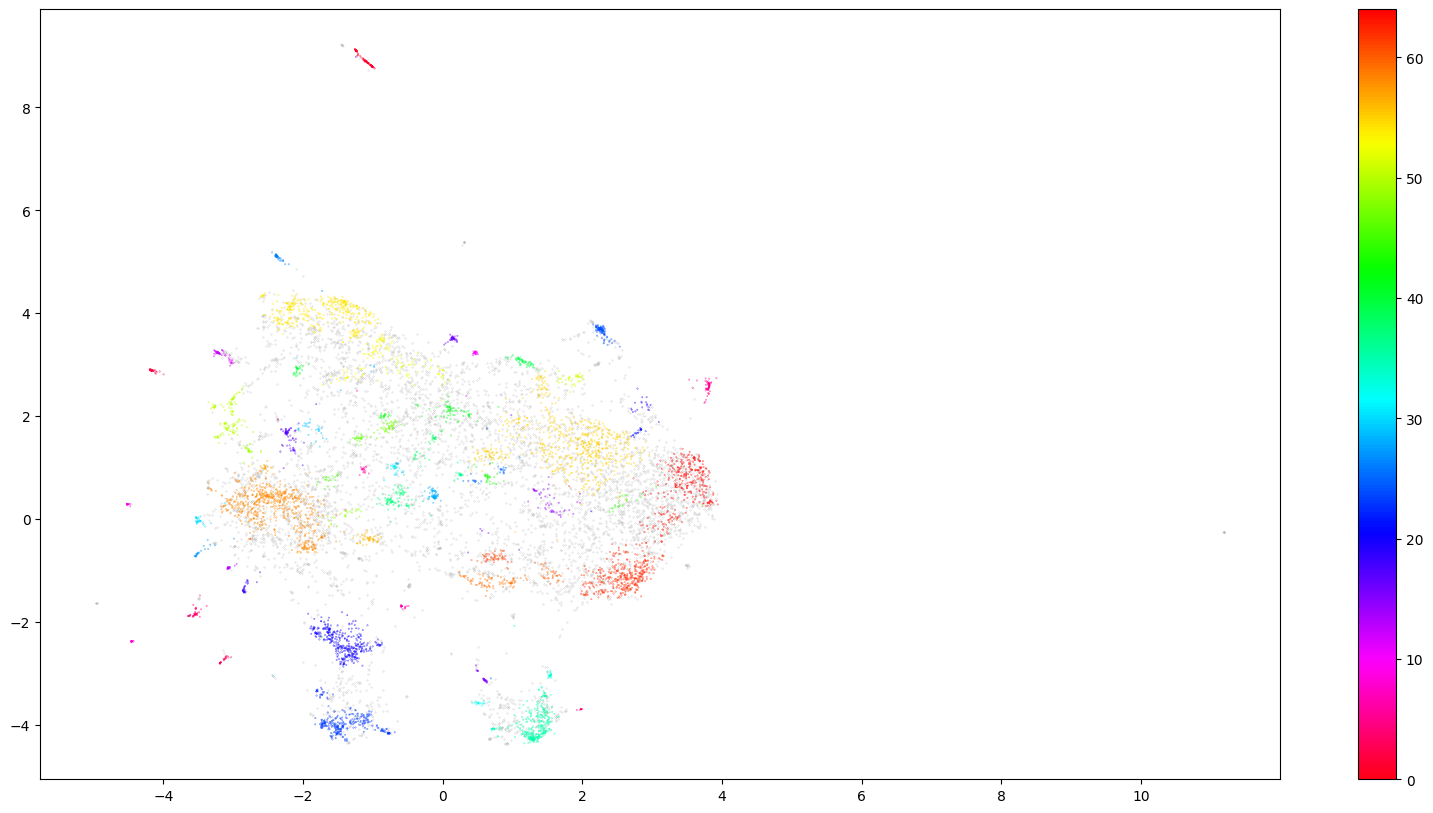

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

# 4. Topic Creation


**Deriving Topics from Clusters**

What we want to know from the generated clusters is what makes one cluster, based on their content, different from another.

How can we derive topics from clustered documents?

To address this, I devised a class-based variant of TF-IDF (c-TF-IDF) that allows me to extract the unique characteristics of each document set in comparison to others.

The intuition behind this method is as follows: When TF-IDF is traditionally applied to a set of documents, it essentially compares the importance of words across the entire document collection.

What if, instead, we treat all documents within a single category (e.g., a cluster) as a single document and apply TF-IDF? The result would be an elongated document per category, and the resulting TF-IDF scores would reveal the significant words associated with a particular topic.


In [9]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

**Topic Extraction from Clusters**

Now, with a single importance value assigned to each word in a cluster, we can proceed to create the topic. By selecting the top 10 most important words in each cluster, we can effectively capture the essence of the cluster and derive a meaningful topic.


In [29]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

**Topic Representation**

To construct a topic representation, we select the top 20 words per topic based on their c-TF-IDF scores. These scores act as proxies for the information density of each word within its respective topic. Therefore, higher scores indicate greater representativeness of the word for the topic.


In [30]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,5755
38,37,754
36,35,676
42,41,392
35,34,390
21,20,359
12,11,350
13,12,316
44,43,262
22,21,141


In [31]:
top_n_words[-1][:10]

[('max', 0.0037380127652118424),
 ('g9v', 0.002477767941910643),
 ('b8f', 0.0024233015453078927),
 ('a86', 0.002281198499768314),
 ('145', 0.002148325703667039),
 ('god', 0.0020219653496139217),
 ('does', 0.002012824083503876),
 ('pl', 0.0019928095330339957),
 ('use', 0.0019833437682712798),
 ('time', 0.001965028775237212)]

In [34]:
top_n_words[38][:10]

[('bike', 0.035299395599382985),
 ('water', 0.02534275352932305),
 ('motorcycle', 0.023560754202009027),
 ('mwra', 0.019709604926981972),
 ('helmet', 0.01578895070936207),
 ('dod', 0.015612785891872316),
 ('bikes', 0.012862788574834794),
 ('ride', 0.01254792045367706),
 ('behanna', 0.0120111880682493),
 ('motorcycles', 0.011864517492565568)]

In [35]:
top_n_words[36][:10]

[('austin', 0.027991297621428927),
 ('utexas', 0.026277248541244337),
 ('houston', 0.017159619591293324),
 ('texas', 0.015501944982257656),
 ('ibm', 0.014000491312121138),
 ('turpin', 0.01088020129732993),
 ('cc', 0.010766473177534758),
 ('ccwf', 0.010217300293872187),
 ('karner', 0.009350298539552705),
 ('lady', 0.009154764686303076)]

In [36]:
top_n_words[42][:10]

[('video', 0.016684396708439776),
 ('card', 0.016006670881944955),
 ('mac', 0.0122331296599495),
 ('thanks', 0.010122050791941884),
 ('atm', 0.01005702230682104),
 ('client', 0.009539287893686528),
 ('snes', 0.009224843453148038),
 ('disk', 0.008486314483310636),
 ('umcc', 0.008430960665151437),
 ('quicktime', 0.008147766208500473)]

# 5. Topic Reduction


**Topic Reduction**

In some cases, depending on the dataset, you may end up with a large number of topics created. While you can adjust the parameters of HDBSCAN, such as the `min_cluster_size`, to obtain fewer topics, it does not offer precise control over the exact number of clusters.

An effective technique, inspired by Top2Vec, involves reducing the number of topics by merging highly similar topic vectors.

We can apply a similar strategy by comparing the c-TF-IDF vectors across topics, identifying the most similar ones, and merging them. Subsequently, we can recalculate the c-TF-IDF vectors to update the representation of the merged topics.


In [37]:
from sklearn.metrics.pairwise import cosine_similarity
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,5755
19,18,950
18,17,805
10,9,403
22,21,392
17,16,390
6,5,350
7,6,316
24,23,262
11,10,173
